 #  Transfer learning model- DenseNet121,DenseNet169 and DenseNet201  (Intel Scene Multi-Class Image Classification)


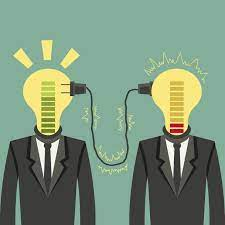

Identifying natural scenes from all around the world is an interesting computer vision problem. In this challenge, we are going to classify six different category Imges.This dataset contains about ~25k images from a wide range of natural scenes from all around the world. The task is to identify which kind of scene can the image be categorized into.

It is a 6 class problem

- Buildings
-Forests
-Mountains
- Glacier
- Street
- Sea


## Content

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

If you check the directory under input (check the top right portion of this notebook), you can see that images are placed inside their respective classes. Separate class label csv file is not given.

So we have two choices
  1. Load images directly from ImageDataGenerator.flow_from_directory
  2. Create a function to load images from directory and create a list for class lables 

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrvmurali","key":"b52d02bd18b2eed468ba2144e5ad2c6b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 338M/346M [00:04<00:00, 127MB/s]
100% 346M/346M [00:04<00:00, 73.6MB/s]


## Given data is in Zip format. So first we have to unzip the files

In [4]:
!unzip "/content/intel-image-classification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

## Import the libraries:

In [5]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam,SGD 
from keras.callbacks import ReduceLROnPlateau 
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout
import warnings
warnings.filterwarnings("ignore")

##Visualize some Random Images from Training set

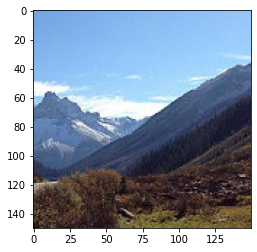

In [6]:
image = load_img("/content/seg_train/seg_train/mountain/10008.jpg")
plt.imshow(image)

## Transforms for image -augmentations


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.2)

train_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/seg_train/seg_train',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test", 
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse',
    seed=2209
) 


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [8]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
#mapping encoded values to class labels
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

## Generator work

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

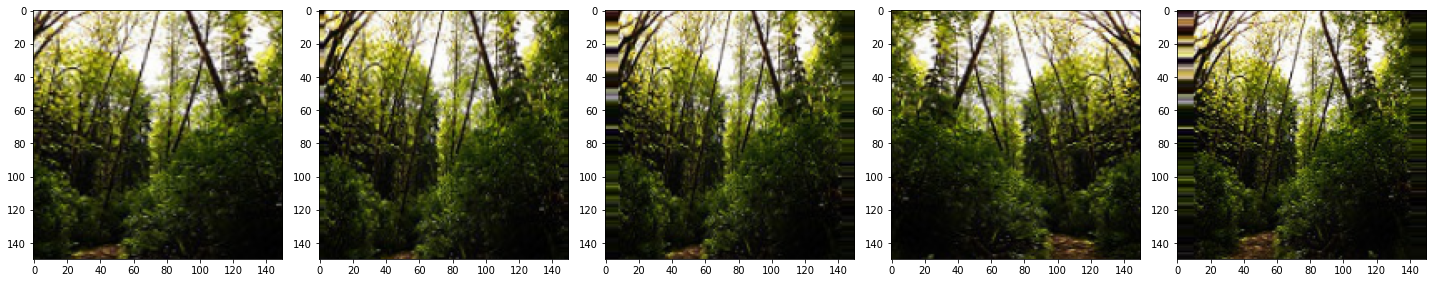

In [11]:
images = [train_generator[0][0][0] for i in range(5)]
plotImages(images)

## DenseNet 

DenseNet is a network architecture where each layer is directly connected to every other layer in a feed-forward fashion (within each dense block). For each layer, the feature maps of all preceding layers are treated as separate inputs whereas its own feature maps are passed on as inputs to all subsequent layers. 
DenseNet achieves a similar accuracy as ResNet, but using less than half the amount of parameters and roughly half the number of FLOPs.

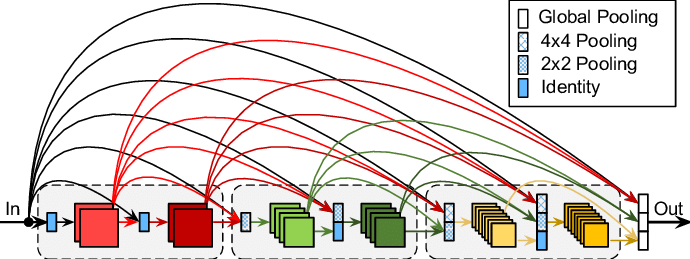

In [12]:
# Hyperparameters:
input_shape = (150,150,3)
batch_size = 32
lr = 0.001
n_class = 6
epochs =20
adam = Adam(lr = lr, beta_1 = 0.9, beta_2 =0.999,amsgrad =False,epsilon =1e-7)

In [13]:
#ReduceLROnPlateau to reduce LR 
lrr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,factor =0.25,min_lr = 0.000003, verbose =1)

In [14]:
#Creating early stopping callback
from  keras.callbacks import EarlyStopping
early_stopping =EarlyStopping(monitor = 'val_accuracy', patience=3) 
#stop the training process if there is no change in val_accuracy for 3 rounds

In [15]:
# Import the model  
from tensorflow.keras.applications.densenet import DenseNet121


pre_trained_model = DenseNet121(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________

In [16]:
from tensorflow.keras import layers
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 9,135,558
Trainable params: 2,098,054
Non-trainable params: 7,037,504
__________________________________________________________________________________________________


In [17]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=20,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)

Epoch 1/20
175/175 [==============================] - 120s 421ms/step - loss: 0.9731 - accuracy: 0.7805 - val_loss: 0.3055 - val_accuracy: 0.8943
Epoch 2/20
175/175 [==============================] - 73s 410ms/step - loss: 0.2768 - accuracy: 0.9017 - val_loss: 0.2793 - val_accuracy: 0.9001
Epoch 3/20
175/175 [==============================] - 71s 410ms/step - loss: 0.2295 - accuracy: 0.9167 - val_loss: 0.2808 - val_accuracy: 0.8997
Epoch 4/20
175/175 [==============================] - 72s 410ms/step - loss: 0.2167 - accuracy: 0.9203 - val_loss: 0.2957 - val_accuracy: 0.9030
Epoch 5/20
175/175 [==============================] - 72s 410ms/step - loss: 0.1951 - accuracy: 0.9280 - val_loss: 0.3113 - val_accuracy: 0.8975
Epoch 6/20
175/175 [==============================] - 72s 411ms/step - loss: 0.1843 - accuracy: 0.9300 - val_loss: 0.3218 - val_accuracy: 0.8975
Epoch 7/20
175/175 [==============================] - 71s 409ms/step - loss: 0.1840 - accuracy: 0.9308 - val_loss: 0.3119 - val_a

## Virtualize Training

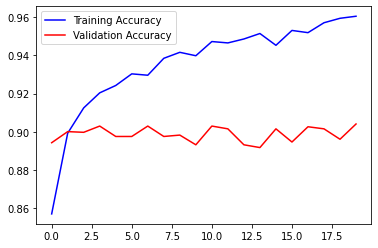

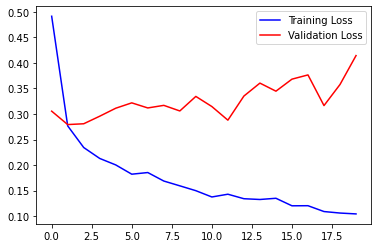

In [18]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(20) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

# Prepare Evaluate Generator for Model

In [19]:
accuracy=model.evaluate_generator(test_generator, steps=len(test_generator)//32,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

2/2 - 1s - loss: 0.3925 - accuracy: 0.9219
Accuracy of the model on the test set:  0.921875


# Test Model performance on custom data:

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

def pred(path):
  test_image = image.load_img(path, target_size = (150,150))
  plt.imshow(test_image)
  test_image=np.expand_dims(test_image,axis=0)
  test_image=np.array(test_image)
  test_image=test_image/255
  prediction =np.argmax(model.predict(test_image),axis=1)
  result={0: 'buildings',1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
  return print(result[prediction[0]])

forest


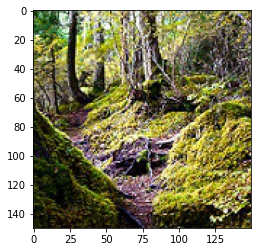

In [21]:
pred('/content/seg_pred/seg_pred/10021.jpg')

street


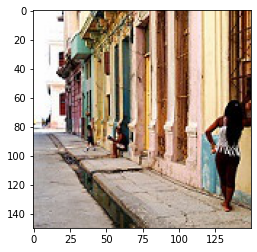

In [22]:
pred('/content/seg_pred/seg_pred/10045.jpg')

## DenseNet169

In [23]:

# Import the model  
from tensorflow.keras.applications.densenet import DenseNet169


pre_trained_model = DenseNet169(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()
  

51879936/51877672 [==============================] - 0s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________

In [24]:
from tensorflow.keras import layers
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 16,051,654
Trainable params: 3,408,774
Non-trainable params: 12,642,880
__________________________________________________________________________________________________


In [25]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=20,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)

Epoch 1/20
175/175 [==============================] - 84s 434ms/step - loss: 4.4304 - accuracy: 0.7572 - val_loss: 0.3432 - val_accuracy: 0.8834
Epoch 2/20
175/175 [==============================] - 73s 419ms/step - loss: 0.2937 - accuracy: 0.9001 - val_loss: 0.2942 - val_accuracy: 0.8979
Epoch 3/20
175/175 [==============================] - 73s 418ms/step - loss: 0.2600 - accuracy: 0.9136 - val_loss: 0.2723 - val_accuracy: 0.9077
Epoch 4/20
175/175 [==============================] - 73s 417ms/step - loss: 0.2322 - accuracy: 0.9163 - val_loss: 0.2924 - val_accuracy: 0.9015
Epoch 5/20
175/175 [==============================] - 73s 420ms/step - loss: 0.1915 - accuracy: 0.9297 - val_loss: 0.2642 - val_accuracy: 0.9099
Epoch 6/20
175/175 [==============================] - 73s 418ms/step - loss: 0.1930 - accuracy: 0.9272 - val_loss: 0.3166 - val_accuracy: 0.8917
Epoch 7/20
175/175 [==============================] - 77s 444ms/step - loss: 0.1797 - accuracy: 0.9325 - val_loss: 0.2640 - val_ac

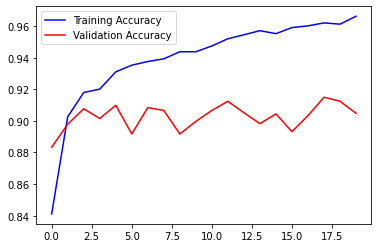

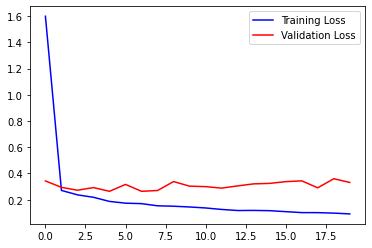

In [26]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(20) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [27]:
accuracy=model.evaluate_generator(test_generator, steps=len(test_generator)//32,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

2/2 - 1s - loss: 0.3246 - accuracy: 0.9219
Accuracy of the model on the test set:  0.921875


## DenseNet201

In [28]:
# Import the model  
from tensorflow.keras.applications.densenet import DenseNet201


pre_trained_model = DenseNet201(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary

74842112/74836368 [==============================] - 0s 0us/step


In [29]:
from tensorflow.keras import layers
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(6, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 22,255,046
Trainable params: 3,933,062
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [30]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(11230/64),
  epochs=20,
  validation_data=validation_generator,
  validation_steps=int(2804/64),
  
  verbose=1
)

Epoch 1/20
175/175 [==============================] - 89s 451ms/step - loss: 4.1094 - accuracy: 0.7656 - val_loss: 0.3457 - val_accuracy: 0.8852
Epoch 2/20
175/175 [==============================] - 76s 434ms/step - loss: 0.3139 - accuracy: 0.8934 - val_loss: 0.2727 - val_accuracy: 0.9033
Epoch 3/20
175/175 [==============================] - 76s 433ms/step - loss: 0.2328 - accuracy: 0.9180 - val_loss: 0.2691 - val_accuracy: 0.9026
Epoch 4/20
175/175 [==============================] - 75s 433ms/step - loss: 0.2068 - accuracy: 0.9249 - val_loss: 0.2654 - val_accuracy: 0.9081
Epoch 5/20
175/175 [==============================] - 75s 432ms/step - loss: 0.1926 - accuracy: 0.9286 - val_loss: 0.2889 - val_accuracy: 0.8950
Epoch 6/20
175/175 [==============================] - 81s 463ms/step - loss: 0.1892 - accuracy: 0.9307 - val_loss: 0.2635 - val_accuracy: 0.9117
Epoch 7/20
175/175 [==============================] - 76s 433ms/step - loss: 0.1635 - accuracy: 0.9382 - val_loss: 0.2637 - val_ac

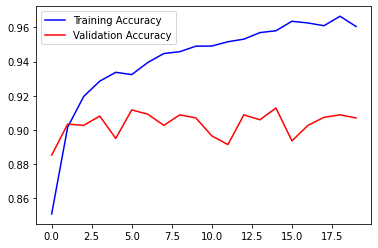

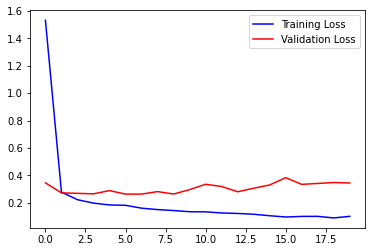

In [31]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(20) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()